In [1]:
import tensorflow as tf

In [2]:
train_data_directory = '/Users/wacats_wh/Desktop/Workspace/chihuahua-vs-muffin/image_dataset/train'
test_data_directory = '/Users/wacats_wh/Desktop/Workspace/chihuahua-vs-muffin/image_dataset/test'

Standardize the input size of image dataset into 224 pixel height and width.

Batch size is 64 due to local machine limitation, taking 64 images at once for training.

In [3]:
image_height = 224
image_width = 224
image_dimension = (image_height, image_width)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_directory,
    labels = 'inferred',
    seed = 8,
    image_size = image_dimension, # Image dimension
    batch_size = batch_size # How many images to load in 1 batch
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_directory,
    labels = 'inferred',
    seed = 8,
    image_size = image_dimension, # Image dimension
    batch_size = batch_size # How many images to load in 1 batch
)

Found 4733 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 1184 files belonging to 2 classes.


2023-12-20 22:47:36.850052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 22:47:36.850155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Have a look at the class names, we expect the image is either a 'Chihuahua' or a 'Muffin'.

In [4]:
class_names = train_ds.class_names
print(class_names)

['chihuahua', 'muffin']


In [5]:
import matplotlib.pyplot as plt
def preview_images(dataset):
    plt.figure(figsize = (10, 10))
    for images, labels in dataset.take(1):
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')

Have a glimpse into the image dataset with their class name.

I do see pug and border collie got labelled as a 'Chihuahua' but it doesn't matter since they are still dogs and not muffins. 😅

2023-12-20 22:47:37.282420: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


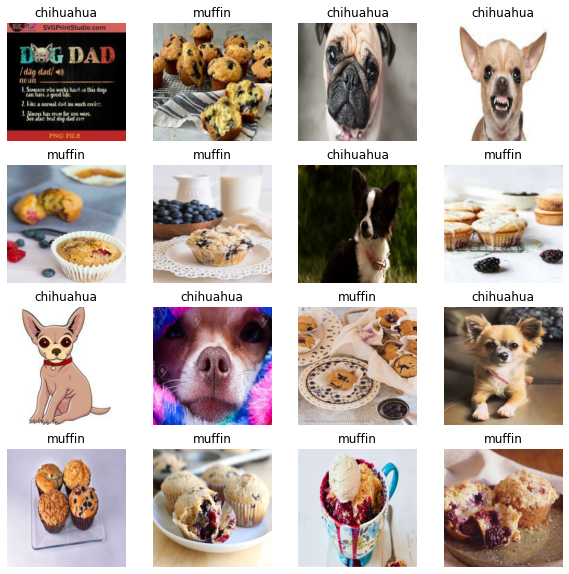

In [6]:
preview_images(train_ds)

Train a simple neural network model using Keras Sequential class.

Layers are provided in a list to the Sequential class.

The first layer will be the input layer taking in the image data and rescale it into the desired image_height and image_width, as well as the channel of 3 signifying the image will be presented to the network with RGB (3) instead of Grayscale (1).

We have several other layers as hidden layers in the neural network. At the output layer, we specify it to have num_of_classes of value 2. This will give a binary classification output of whether the image is a Chihuahua or a Muffin.

The filter size is 16, 32, 64 after the images go through convolutional layers. We apply padding rule 'same' to the convolution layers. The activation function is 'relu'.

We introduce one flatten layer after the convolutional layers to flatten the output into 1-Dimension. 

In [9]:
from tensorflow import keras
from tensorflow.python.keras import layers

num_of_classes = len(class_names)

model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_of_classes) # Output layer
])

Using 'adam' as the optimizer for the neural network.

In the loss function, `from_logits = True` is mentioned because we are trying to calculate the "probability" of whether the output is a Chihuahua or a Muffin. Neural networks in its original form is not able to come up with probability, so `from_logits = True` is used for the model to calculate probability for classification result.

We will use accuracy as the performance metric since accuracy will be suitable in this case.

In [10]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

epochs = 5

history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = epochs
)

Epoch 1/5


2023-12-20 23:58:31.750755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.7095

2023-12-20 23:58:49.252834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 21s 243ms/step - loss: 0.6482 - accuracy: 0.7095 - val_loss: 0.4231 - val_accuracy: 0.8133
Epoch 2/5
74/74 [==============================] - 17s 219ms/step - loss: 0.3536 - accuracy: 0.8441 - val_loss: 0.3292 - val_accuracy: 0.8564
Epoch 3/5
74/74 [==============================] - 18s 228ms/step - loss: 0.2816 - accuracy: 0.8857 - val_loss: 0.3005 - val_accuracy: 0.8784
Epoch 4/5
74/74 [==============================] - 17s 223ms/step - loss: 0.2177 - accuracy: 0.9117 - val_loss: 0.3027 - val_accuracy: 0.8733
Epoch 5/5
74/74 [==============================] - 18s 228ms/step - loss: 0.1637 - accuracy: 0.9394 - val_loss: 0.3893 - val_accuracy: 0.8733


In [12]:
def plot_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

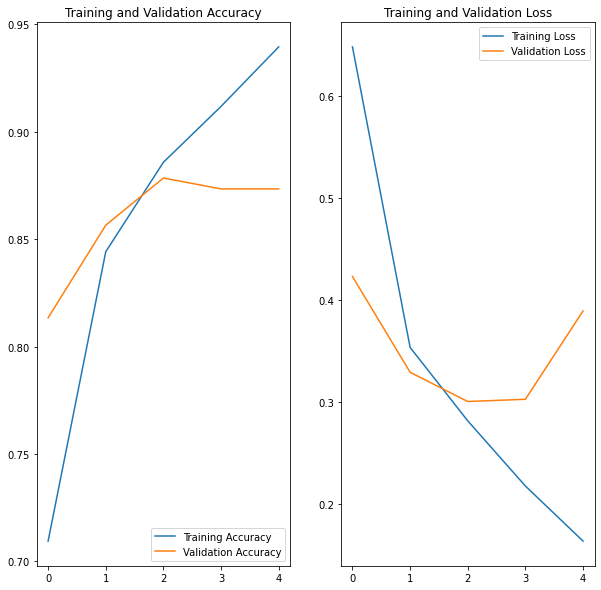

In [13]:
plot_history(history, epochs)

Training accuracy and training loss goes well after several epochs.

There is a slight drop in validation accuracy at the 4th epoch and onwards, as well as an increase of loss right after the 4th epoch.

We may want to introduce some data augmentation to the dataset to improve the robustness of the model.

In [17]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip(
            'horizontal',
            input_shape = (image_height, image_width, 3
        )),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1)
    ])

We introduce layers to randomly flip the image dataset horizontally, randomly rotate the image and also zoom randomly into the image.

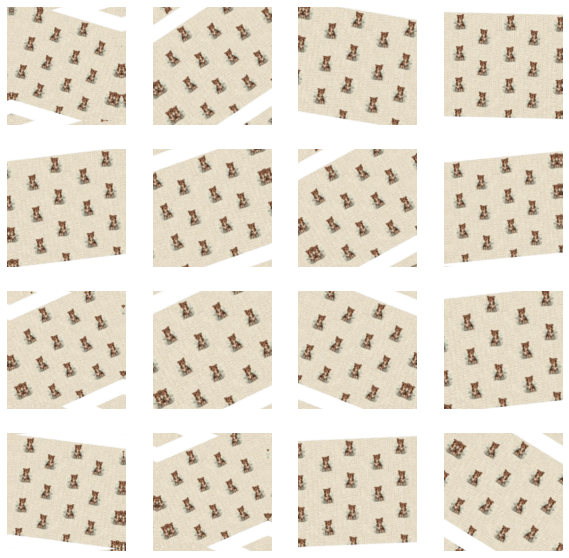

In [18]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
    for i in range(16):
        with tf.device('/cpu:0'):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

With similar model to the previous model, we add data augmentation layers at the beginning of the model. Hoping this would make the model perform better with more robustness, trying to reduce the overfitting into dataset.

In [19]:
augmented_model = keras.Sequential([
    data_augmentation, # Introduce data augmentation layer
    keras.layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # Introduce dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_of_classes) # Output layer
])

In [20]:
augmented_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

augmented_model_epochs = 10

augmented_model_history = augmented_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = augmented_model_epochs
)

Epoch 1/10


2023-12-21 16:30:22.955751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6996

2023-12-21 16:31:00.093939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 40s 512ms/step - loss: 0.6290 - accuracy: 0.6996 - val_loss: 0.4081 - val_accuracy: 0.8260
Epoch 2/10
74/74 [==============================] - 37s 495ms/step - loss: 0.3847 - accuracy: 0.8375 - val_loss: 0.4479 - val_accuracy: 0.8159
Epoch 3/10
74/74 [==============================] - 38s 504ms/step - loss: 0.3413 - accuracy: 0.8587 - val_loss: 0.4782 - val_accuracy: 0.8049
Epoch 4/10
74/74 [==============================] - 39s 518ms/step - loss: 0.2954 - accuracy: 0.8781 - val_loss: 0.3348 - val_accuracy: 0.8615
Epoch 5/10
74/74 [==============================] - 41s 542ms/step - loss: 0.2738 - accuracy: 0.8836 - val_loss: 0.3252 - val_accuracy: 0.8632
Epoch 6/10
74/74 [==============================] - 41s 538ms/step - loss: 0.2475 - accuracy: 0.9001 - val_loss: 0.3220 - val_accuracy: 0.8606
Epoch 7/10
74/74 [==============================] - 42s 551ms/step - loss: 0.2391 - accuracy: 0.9037 - val_loss: 0.3337 - val_accuracy: 0.8590
Epoch 8/10

Comparing between the model before and after adding the data augmentation layer, both models have similar accuracy (0.8733 vs 0.8632) around the 5th epoch.

However the model had a sharp drop in accuracy as well increase in loss after the 5th epoch.

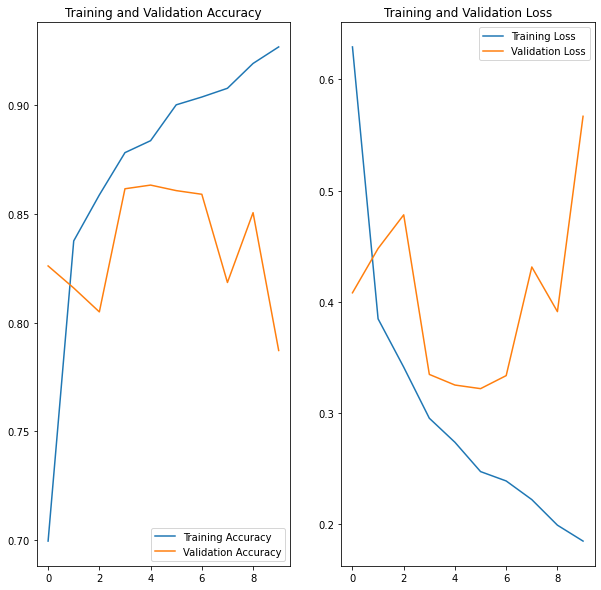

In [21]:
plot_history(augmented_model_history, augmented_model_epochs)

We try to experiment on the task with transferred learning by using existing model ResNet50.

We do not want to reuse the classifying layer or the final layer since the output shape will be different in our experiment. We are also setting the `trainable` attribute to `False` to freeze the model from learning the dataset, since we want to see how the existing model is able to perform in this experiment.

In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet50_base_model = ResNet50(
    weights = 'imagenet',
    include_top = False, # Don't reuse classifier/final layer
    input_shape = (image_height, image_width, 3)
)

# Freeze model from it's weightage being adjusted
resnet50_base_model.trainable = False

Declaring the model by using Functional API. Providing the previous layer as argument into the new layer to be added on.

We will reuse the data augmentation layer we have previously created at the beginning of the neural network. We add a final Dense layer with `num_of_classes = 2` since the task is a binary classification task of Chihuahua vs Muffin.

In [24]:
input_layer = keras.Input(
    shape = (image_height, image_width, 3)
)
x = data_augmentation(input_layer)
x = resnet50_base_model(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(num_of_classes)(x)
resnet50_transferred_model = keras.Model(input_layer, output_layer)

In [25]:
resnet50_transferred_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

resnet50_epochs = 10

resnet50_history = resnet50_transferred_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = resnet50_epochs
)

Epoch 1/10


2023-12-21 16:49:26.309566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9309

2023-12-21 16:50:42.660581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 93s 1s/step - loss: 0.1613 - accuracy: 0.9309 - val_loss: 0.0293 - val_accuracy: 0.9907
Epoch 2/10
74/74 [==============================] - 96s 1s/step - loss: 0.0556 - accuracy: 0.9804 - val_loss: 0.0234 - val_accuracy: 0.9941
Epoch 3/10
74/74 [==============================] - 103s 1s/step - loss: 0.0484 - accuracy: 0.9823 - val_loss: 0.0213 - val_accuracy: 0.9949
Epoch 4/10
74/74 [==============================] - 105s 1s/step - loss: 0.0402 - accuracy: 0.9842 - val_loss: 0.0220 - val_accuracy: 0.9932
Epoch 5/10
74/74 [==============================] - 107s 1s/step - loss: 0.0343 - accuracy: 0.9877 - val_loss: 0.0225 - val_accuracy: 0.9924
Epoch 6/10
74/74 [==============================] - 107s 1s/step - loss: 0.0286 - accuracy: 0.9903 - val_loss: 0.0215 - val_accuracy: 0.9907
Epoch 7/10
74/74 [==============================] - 105s 1s/step - loss: 0.0274 - accuracy: 0.9894 - val_loss: 0.0203 - val_accuracy: 0.9916
Epoch 8/10
74/74 [========

In this tranferred learning example using ResNet50, the neural network is able to perform extremely well.

The training accuracy is able to rise quickly from 0.93 into 0.98 after the first epoch, while the validation accuracy are constantly staying around above the 0.99 range.

The training loss is also dropping quickly right after the first epoch, while the validation loss below 0.03.

This proves that the transferred learning model used - ResNet50 is able to identify Chihuahua and Muffins with:

Training Accuracy: 0.9920

Validation Accuracy: 0.9916

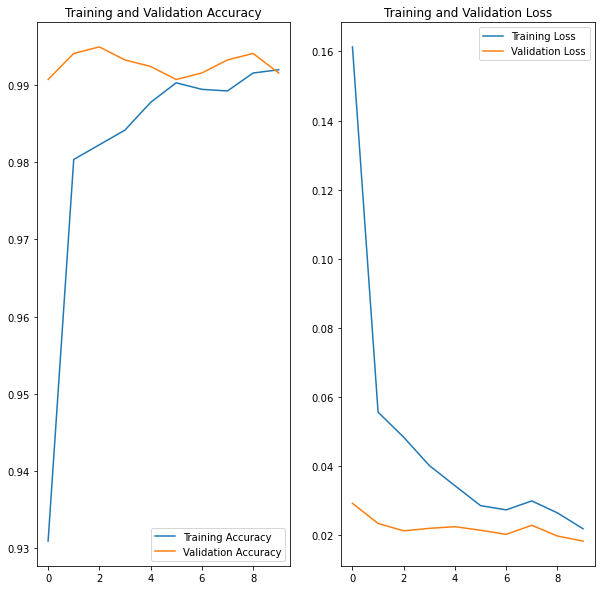

In [26]:
plot_history(resnet50_history, resnet50_epochs)

This is just a fun project to showcase how modern neural networks are actually able to identify Chihuahua and Muffins as opposed to the modern Internet meme that AIs (of course including deep learning neural networks) can be confused by mere images of Chihuahua and Muffins 😜

![Internet meme of Chihuahua vs Muffin](chihuahua_vs_muffin.jpg)